In [1]:
import tensorflow as tf
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from sklearn.utils.class_weight import compute_class_weight

import loader
import importlib
importlib.reload(loader)

from gesture_drawing import GestureDrawing
from loader import load_gesture, save_model, load_classes, load_model

In [2]:
class_names = ["circle", "gate", "lightning", "star", "waves", "spiral", "bounce", "garbage"]

In [3]:
# Augment, and rasterize a drawing
def augment_and_rasterize(drawing: GestureDrawing):
    rasters = np.zeros((10, 28, 28))
    ref = drawing.reflected()
    for r in range(5):
        rasters[r] = drawing.rotated((r-2) * math.pi/18).normalized(23).translated(2.5,2.5).rasterized()
        rasters[r+5] = ref.rotated((r-2) * math.pi/18).normalized(23).translated(2.5,2.5).rasterized()
    return rasters

def plot_drawing(x: np.ndarray, y: int):
	print("Label:", class_names[int(y)])
	plt.figure(figsize=(2,2))
	plt.imshow(x.squeeze())
	plt.axis('off')
	plt.show()

def choose_random(l: list, n):
    return list(map(lambda i: l[i], np.random.choice(len(l), min(int(n), len(l)), replace=False)))

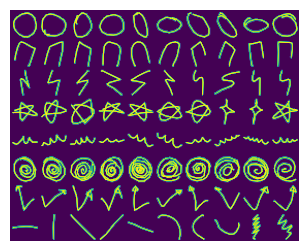

In [4]:
# Load the gestures

drawings: list[list[GestureDrawing]] = []
for class_name in class_names:
    drawings.append(load_gesture(class_name))

# Add additional garbage data
garbage_count = len(drawings[-1])
drawings[-1] += choose_random(load_gesture("garbage_square"), garbage_count/10)

img = np.empty((0, 280))
for gesture_drawings in drawings:
    data = np.zeros((28, 280))
    for i, d in enumerate(np.random.choice(len(gesture_drawings), min(10, len(gesture_drawings)), replace=False)):
        data[:,i*28:i*28+28] = augment_and_rasterize(gesture_drawings[i])[random.randint(0, 9)]
    img = np.concatenate([img, data])
plt.figure(figsize=(20,3))
plt.axis('off')
plt.imshow(img)

In [5]:
# rasterize and split into train and test data

test_split = 0.0
x_train = np.empty((0, 28, 28, 1))
y_train = np.empty((0))
x_test: np.ndarray = np.empty((0, 28, 28, 1))
y_test = np.empty((0))

for i, class_name in enumerate(class_names):
    count = len(drawings[i])
    test_indices = set(np.random.choice(count, int(test_split * count), replace=False))
    train_indices = set(range(count)) - test_indices

    train_data = np.array([augment_and_rasterize(drawings[i][j]) for j in train_indices]).reshape(-1, 28, 28, 1)
    test_data = np.array([augment_and_rasterize(drawings[i][j]) for j in test_indices]).reshape(-1, 28, 28, 1)
    x_train = np.concatenate([x_train, train_data])
    y_train = np.concatenate([y_train, np.full(len(train_data), i)])
    x_test = np.concatenate([x_test, test_data])
    y_test = np.concatenate([y_test, np.full(len(test_data), i)])

    print(f"{class_name}: {count*10} total, {len(train_data)} train, {len(test_data)} test")
    
print("\nTrain:", len(x_train))
print("Test:", len(x_test))

circle: 1410 total, 1410 train, 0 test
gate: 560 total, 560 train, 0 test
lightning: 2280 total, 2280 train, 0 test
star: 570 total, 570 train, 0 test
waves: 240 total, 240 train, 0 test
spiral: 530 total, 530 train, 0 test
bounce: 550 total, 550 train, 0 test
garbage: 4170 total, 4170 train, 0 test

Train: 10310
Test: 0


10310
Label: garbage


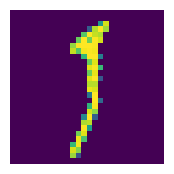

In [7]:
# Let's see a random image from the training data
random_index = random.randint(0, len(x_train)-1)
print(len(y_train))
plot_drawing(x_train[random_index], y_train[random_index])

In [8]:
# function for training the model
def train(model: tf.keras.Model, epochs=1):

	class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
	history = model.fit(x_train, y_train,
			validation_data=(x_test, y_test),
			batch_size=256,
			epochs=epochs,
			class_weight={i:w for i,w in enumerate(class_weight)})
		
	plt.subplot(1,2,1)
	plt.plot(history.history['accuracy'])
	if len(x_test) > 0: plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')

	plt.subplot(1,2,2)
	plt.plot(history.history['loss'])
	if len(x_test) > 0: plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')

	plt.show()

In [9]:
# load doodlenet
base_class_names = load_classes("doodleNet")
base_model = load_model("doodleNet")
for layer in base_model.layers: layer._name = "doodleNet_"+layer._name
print(len(base_class_names), 'classes')
base_model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

345 classes
Model: "doodleNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 doodleNet_conv2d (Conv2D)   (None, 28, 28, 16)        160       
                                                                 
 doodleNet_conv2d_1 (Conv2D)  (None, 28, 28, 16)       2320      
                                                                 
 doodleNet_max_pooling2d (Ma  (None, 14, 14, 16)       0         
 xPooling2D)                                                     
                                                                 
 doodleNet_conv2d_2 (Conv2D)  (None, 14, 14, 32)       4640      
                                                                 
 doodleNet_conv2d_3 (Conv2D)  (None, 14, 14, 32)       9248      
                                                                 
 doodleNet_max_pooling2d_1 (  (Non

In [10]:
# transfer base model to new model

base_conv_layers = tf.keras.Sequential(base_model.layers[0:9], base_model.name)
base_conv_layers.trainable = False

model = tf.keras.Sequential(name=f"gesture_recognizer", layers=[
    base_conv_layers,
    layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    # layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    layers.Conv2D(64, (7, 7), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size =(2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.8),
    layers.Dense(len(class_names), activation='softmax'),
])
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(name="loss"),
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])
model.summary()

Model: "gesture_recognizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 doodleNet (Sequential)      (None, 3, 3, 64)          71792     
                                                                 
 conv2d (Conv2D)             (None, 3, 3, 64)          102464    
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          200768    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 64)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                

Epoch 1/20
41/41 [==============================] - 3s 60ms/step - loss: 1.6756 - accuracy: 0.2234
Epoch 2/20
41/41 [==============================] - 2s 54ms/step - loss: 1.0077 - accuracy: 0.4123
Epoch 3/20
41/41 [==============================] - 2s 54ms/step - loss: 0.7849 - accuracy: 0.4960
Epoch 4/20
41/41 [==============================] - 3s 63ms/step - loss: 0.6794 - accuracy: 0.5530
Epoch 5/20
41/41 [==============================] - 2s 57ms/step - loss: 0.6074 - accuracy: 0.5855
Epoch 6/20
41/41 [==============================] - 2s 49ms/step - loss: 0.5394 - accuracy: 0.6279
Epoch 7/20
41/41 [==============================] - 2s 47ms/step - loss: 0.5076 - accuracy: 0.6589
Epoch 8/20
41/41 [==============================] - 2s 53ms/step - loss: 0.4676 - accuracy: 0.6896
Epoch 9/20
41/41 [==============================] - 2s 59ms/step - loss: 0.4428 - accuracy: 0.7174
Epoch 10/20
41/41 [==============================] - 2s 53ms/step - loss: 0.4101 - accuracy: 0.7345
Epoch 11/

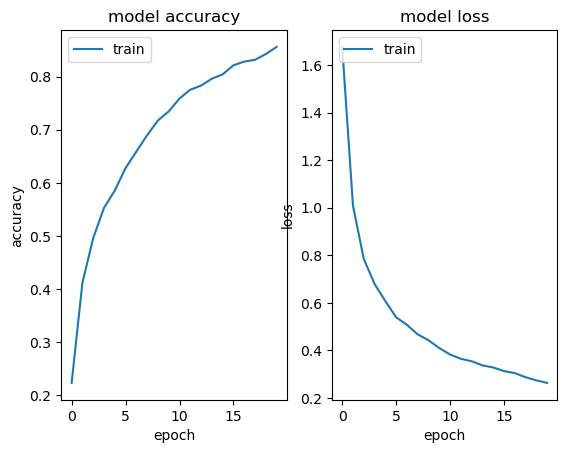

In [11]:
# Train the new model
train(model, epochs=20) # 10 is good

Epoch 1/5
41/41 [==============================] - 2s 54ms/step - loss: 0.2663 - accuracy: 0.8600
Epoch 2/5
41/41 [==============================] - 2s 52ms/step - loss: 0.2594 - accuracy: 0.8672
Epoch 3/5
41/41 [==============================] - 2s 51ms/step - loss: 0.2433 - accuracy: 0.8694
Epoch 4/5
41/41 [==============================] - 2s 57ms/step - loss: 0.2377 - accuracy: 0.8754
Epoch 5/5
41/41 [==============================] - 2s 51ms/step - loss: 0.2245 - accuracy: 0.8837


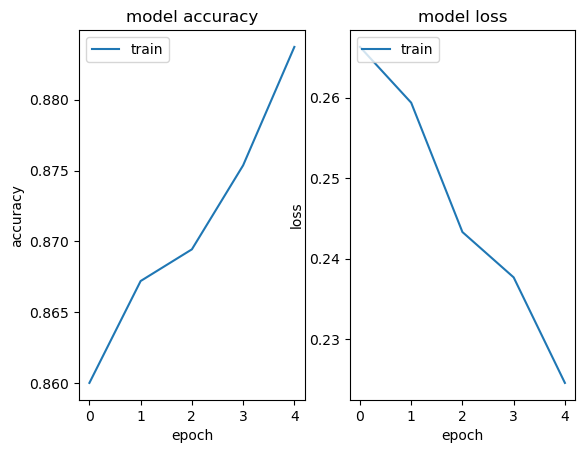

In [12]:
# optionally unfreeze to fine tune
model.layers[0].trainable = True
train(model, epochs=5) # 2 is good

60/60 [==============================] - 0s 4ms/step
Accuracy: 1685/1900 = 88.68%
Prediction Label: star
  circle: 0.00
  gate: 0.00
  lightning: 0.00
  star: 97.29
  waves: 0.00
  spiral: 0.00
  bounce: 0.00
  garbage: 2.71
Label: garbage


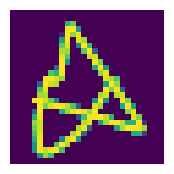

In [416]:
# Evaluate on test data and show a random incorrect predictions
predictions: np.ndarray = model.predict(x_test)

bad_labels = np.argwhere((y_test == predictions.argmax(axis=1)) == False).squeeze()

successes = len(predictions)-len(bad_labels)
accuracy = successes * 100 / len(predictions)
print(f'Accuracy: {successes}/{len(predictions)} = {accuracy:0.2f}%'.format())

# choose a random index with incorrect label 
idx = np.random.choice(bad_labels)
predictions: np.ndarray = predictions[idx]

print("Prediction Label:", class_names[predictions.argmax()])
for i, class_name in enumerate(class_names):
	print(f'  {class_name}: {predictions[i] * 100:.2f}')
plot_drawing(x_test[idx], y_test[idx])

In [13]:
save_model(model, class_names)

Saving model to models/gesture_recognizer


In [17]:
%load_ext tensorboard
%tensorboard --logdir logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
W0405 11:22:03.803176 6212972544 plugin_event_accumulator.py:323] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.